In [1]:
import sys
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
print(os.getcwd())

C:\Users\sleepybear\TerritoryGame_Maze\Territory_complex


In [2]:
sys.path.append('C:/Users/sleepybear/TerritoryGame_Maze')
from TerritoryGame_MaPolicy import PPO  #指定路径导入一个名为TerritoryGame_MaPolicy的模块

In [3]:
sys.path.append('C:/Users/sleepybear/TerritoryGame_Maze/Territory_complex')
from TerritoryGame_New_Env import TerritoryBattleEnvCoop

In [4]:
import logging

In [5]:
import tensorflow as tf
import numpy as np

In [6]:
sys.path.append('C:/Users/sleepybear/TerritoryGame_Maze')
from visualization import Visualization  # 导入可视化类

In [7]:
save_path = "C:/Users/sleepybear/TerritoryGame_Maze/model"
files = os.listdir(os.path.dirname(save_path))
print("Files in directory:", files)

Files in directory: ['.ipynb_checkpoints', 'IMG_Blue.PNG', 'IMG_Blue_Gray.png', 'IMG_Red.PNG', 'IMG_Red_Gray.png', 'logs', 'Main.ipynb', 'model', 'output.txt', 'TerritoryGame_MaPolicy.py', 'Territory_complex', 'TerrittoryGame_Env.py', 'training.log', 'visualization.py', '__pycache__']


In [8]:
import os
# 确保保存路径存在
save_directory = "model"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

In [9]:
import scipy.spatial

In [10]:
import time

In [11]:
def compute_policy_similarity(policy1, policy2):
    return scipy.spatial.distance.cosine(policy1.flatten(), policy2.flatten())
def detect_policy_switch(previous_policy, current_policy, threshold=0.1):
    return np.linalg.norm(previous_policy - current_policy) > threshold

In [12]:
def main():
    env = TerritoryBattleEnvCoop(grid_size=12, max_steps=150)
    num_agents = env.num_agents
    state_size = env.observation_space.shape[0] * env.observation_space.shape[1]
    action_size = env.action_space.n
    
    ppo = PPO(state_size=state_size, action_size=action_size, num_agents=num_agents)
    ppo.load("C:/Users/sleepybear/TerritoryGame_Maze/model/ppo_Territory_model")

    num_episodes = 100
    batch_size = 32

    vis = Visualization(env)

    # 创建一个新的日志目录，每次运行时带有时间戳
    log_dir = os.path.join("logs", "analysis", f"run_{int(time.time())}")
    summary_writer = tf.summary.create_file_writer(log_dir)

    with open('output.txt', 'w') as file:
        file.write("Episode,Total_Red_Reward,Total_Blue_Reward,Red_Territories,Blue_Territories\n")

        win_counts = np.zeros(num_agents)
        previous_policies = [None] * num_agents
        policy_switches = np.zeros(num_agents)

        for episode in range(num_episodes):
            state = env.reset().flatten()
            done = False
            total_red_reward = 0
            total_blue_reward = 0
            step_count = 0

            all_states, all_actions, all_rewards_per_step, all_old_probs, all_values = [], [], [], [], []
            red_rewards, blue_rewards = [], []
            policy_similarities = []

            while not done and step_count < env.max_steps:
                step_count += 1

                actions = []
                action_probs = []
                policies = []

                for agent_index in range(num_agents):
                    action, policy = ppo.get_action(state, agent_index)
                    actions.append(action)
                    action_probs.append(policy)
                    policies.append(policy)

                next_state, rewards, done, info = env.step(actions)

                all_states.append(state)
                all_actions.append(actions)
                all_rewards_per_step.append(np.sum(rewards))
                all_old_probs.append(action_probs)

                red_rewards.append(np.sum([reward if agent['team'] == 'red' else 0 for reward, agent in zip(rewards, env.agents)]))
                blue_rewards.append(np.sum([reward if agent['team'] == 'blue' else 0 for reward, agent in zip(rewards, env.agents)]))

                # 记录对抗结果
                red_team_wins = info['red_count'] > info['blue_count']
                blue_team_wins = info['blue_count'] > info['red_count']

                for i, agent in enumerate(env.agents):
                    if agent['team'] == 'red' and red_team_wins:
                        win_counts[i] += 1
                    elif agent['team'] == 'blue' and blue_team_wins:
                        win_counts[i] += 1

                # 计算策略相似性
                for i in range(num_agents):
                    for j in range(i + 1, num_agents):
                        similarity = compute_policy_similarity(policies[i], policies[j])
                        policy_similarities.append(similarity)

                # 检测策略切换
                for agent_index in range(num_agents):
                    if previous_policies[agent_index] is not None:
                        if detect_policy_switch(previous_policies[agent_index], policies[agent_index]):
                            policy_switches[agent_index] += 1
                    previous_policies[agent_index] = policies[agent_index]

                for agent_index in range(num_agents):
                    value = ppo.value_models[agent_index](tf.convert_to_tensor(state[None, :])).numpy()[0]
                    all_values.append(value)

                state = next_state.flatten()
                total_red_reward += np.sum([reward if agent['team'] == 'red' else 0 for reward, agent in zip(rewards, env.agents)])
                total_blue_reward += np.sum([reward if agent['team'] == 'blue' else 0 for reward, agent in zip(rewards, env.agents)])

                vis.update(episode)
                env.handle_events()

            if (episode + 1) % batch_size == 0:
                with summary_writer.as_default():
                    for agent_index in range(num_agents):
                        tf.summary.scalar(f"Agent_{agent_index}_Reward", total_red_reward if env.agents[agent_index]['team'] == 'red' else total_blue_reward, step=episode)
                        tf.summary.scalar(f"Agent_{agent_index}_Win_Rate", win_counts[agent_index] / (episode + 1), step=episode)
                        tf.summary.scalar(f"Agent_{agent_index}_Policy_Switches", policy_switches[agent_index], step=episode)
                    tf.summary.scalar(f"Average_Policy_Similarity", np.mean(policy_similarities), step=episode)

            output = (
                f"{episode + 1},{total_red_reward},{total_blue_reward},"
                f"{info['red_count']},{info['blue_count']}\n"
            )
            print(output)
            logging.info(f"Episode {episode + 1} completed: {output.strip()}")
            file.write(output)
            
            # 保存模型
        ppo.save(os.path.join(save_directory, "ppo_Territory_complex_model"))

        vis.show()
        summary_writer.close()
        logging.info("Training completed.")

if __name__ == "__main__":
    try:
        main()
    except SystemExit:
        pass


Loading model from: C:/Users/sleepybear/TerritoryGame_Maze/model/ppo_Territory_model_policy_0.h5
Loading model from: C:/Users/sleepybear/TerritoryGame_Maze/model/ppo_Territory_model_policy_1.h5
Loading model from: C:/Users/sleepybear/TerritoryGame_Maze/model/ppo_Territory_model_policy_2.h5
Loading model from: C:/Users/sleepybear/TerritoryGame_Maze/model/ppo_Territory_model_policy_3.h5
Loading model from: C:/Users/sleepybear/TerritoryGame_Maze/model/ppo_Territory_model_value_0.h5
Loading model from: C:/Users/sleepybear/TerritoryGame_Maze/model/ppo_Territory_model_value_1.h5
Loading model from: C:/Users/sleepybear/TerritoryGame_Maze/model/ppo_Territory_model_value_2.h5
Loading model from: C:/Users/sleepybear/TerritoryGame_Maze/model/ppo_Territory_model_value_3.h5
1,35.799999999999976,27.399999999999977,64,31

Attacker 2 (Team blue) attacks Enemy 1 (Team red) at position (3, 9)
Team blue (Agent 2) receives +10 reward. Total reward: 9.9
2,21.100000000000016,46.19999999999992,42,49

Attacke

In [12]:
# 启动 TensorBoard
!tensorboard --logdir logs/analysis --port=6010
#http://localhost:6010

2024-09-02 09:18:52.535133: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-02 09:18:53.975903: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.17.0 at http://localhost:6010/ (Press CTRL+C to quit)


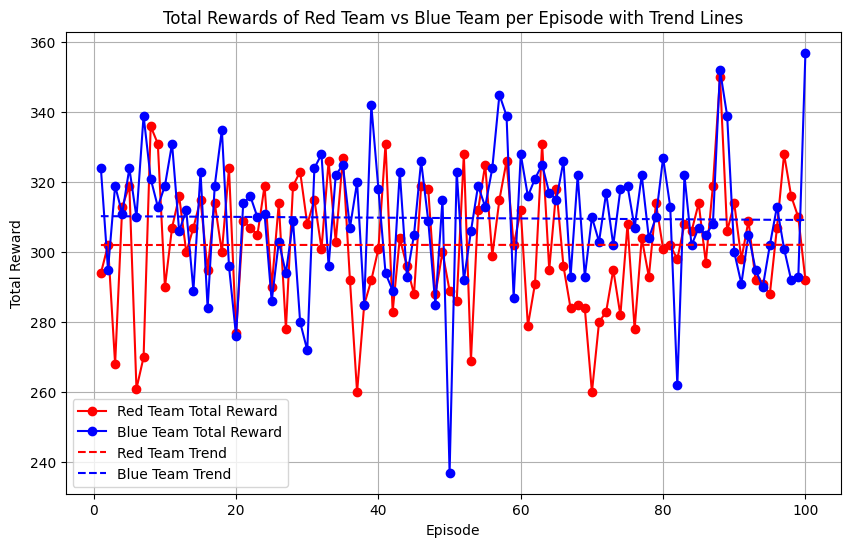

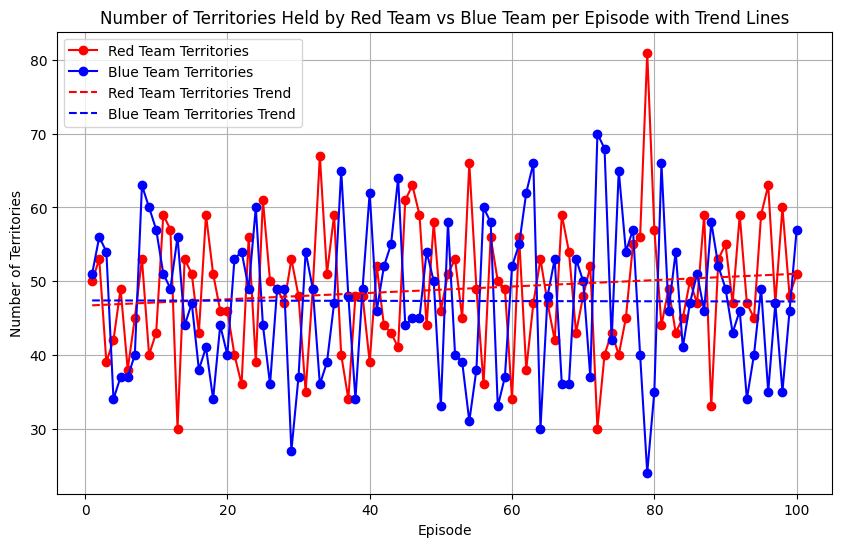

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取CSV文件并创建DataFrame
file_path = 'C:/Users/sleepybear/TerritoryGame_Maze/output.txt'
df = pd.read_csv(file_path)

# 为红队和蓝队的总奖励绘制趋势线
plt.figure(figsize=(10, 6))

# 绘制原始数据点
plt.plot(df['Episode'], df['Total_Red_Reward'], label='Red Team Total Reward', color='red', marker='o')
plt.plot(df['Episode'], df['Total_Blue_Reward'], label='Blue Team Total Reward', color='blue', marker='o')

# 计算红队和蓝队奖励的趋势线
z_red = np.polyfit(df['Episode'], df['Total_Red_Reward'], 1)
p_red = np.poly1d(z_red)
plt.plot(df['Episode'], p_red(df['Episode']), color='red', linestyle='--', label='Red Team Trend')

z_blue = np.polyfit(df['Episode'], df['Total_Blue_Reward'], 1)
p_blue = np.poly1d(z_blue)
plt.plot(df['Episode'], p_blue(df['Episode']), color='blue', linestyle='--', label='Blue Team Trend')

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards of Red Team vs Blue Team per Episode with Trend Lines')
plt.legend()
plt.grid(True)
plt.show()

# 为红队和蓝队的领土数量绘制趋势线
plt.figure(figsize=(10, 6))

# 绘制原始数据点
plt.plot(df['Episode'], df['Red_Territories'], label='Red Team Territories', color='red', marker='o')
plt.plot(df['Episode'], df['Blue_Territories'], label='Blue Team Territories', color='blue', marker='o')

# 计算红队和蓝队领土数量的趋势线
z_red_terr = np.polyfit(df['Episode'], df['Red_Territories'], 1)
p_red_terr = np.poly1d(z_red_terr)
plt.plot(df['Episode'], p_red_terr(df['Episode']), color='red', linestyle='--', label='Red Team Territories Trend')

z_blue_terr = np.polyfit(df['Episode'], df['Blue_Territories'], 1)
p_blue_terr = np.poly1d(z_blue_terr)
plt.plot(df['Episode'], p_blue_terr(df['Episode']), color='blue', linestyle='--', label='Blue Team Territories Trend')

plt.xlabel('Episode')
plt.ylabel('Number of Territories')
plt.title('Number of Territories Held by Red Team vs Blue Team per Episode with Trend Lines')
plt.legend()
plt.grid(True)
plt.show()